In [1]:
from HeaderP import *

In [2]:
import pylab
import matplotlib.pylab as plt
import matplotlib
import numpy as np
import os, pickle

In [3]:
bgdata=pd.read_pickle('./Data/Buck_g2_79e12.pkl')
bgdata['R']=np.sqrt(bgdata['x_today']**2+bgdata['y_today']**2)
bgdata['R_bir']=np.sqrt(bgdata['x_birth']**2+bgdata['y_birth']**2)
datafiles=pd.read_pickle('./Data/trace_stars/2.79e12.00500_trace.dat')

In [4]:
indes=bgdata.index.values
import random
random.shuffle(indes)
selind=indes[:50000]
bgdata=bgdata.iloc[selind]

In [5]:
import natsort 
dirFiles = os.listdir('./Data/trace_stars/')
dirFiles = natsort.natsorted(dirFiles,reverse=False)


In [39]:
#len(dirFiles)
datafiles=pd.DataFrame(pd.read_pickle('./Data/trace_stars/'+dirFiles[100]))
datafiles['R']=np.sqrt(datafiles['x']**2+datafiles['y']**2)
datafiles=pd.merge(datafiles,bgdata[['R_bir','z_birth','iords']],left_on='iords',
                      right_on='iords',how='inner')

scale_fe=0.250019907951355/np.std(datafiles['feh'])
scale_o=0.10861970484256744/np.std(datafiles['ofe'])
datafiles['feh_scale']=datafiles['feh']*scale_fe-0.0906638577580452-np.mean(datafiles['feh'])
datafiles['ofe_scale']=datafiles['ofe']*scale_o+0.08182460814714432-np.mean(datafiles['ofe'])
#datafiles['R']
print(len(datafiles))

4174


In [40]:
def getave_age(age,feh,jz=False,jzs=[],fuc=np.median,Nbin=50):
    sgm=np.std(feh)
    meanfeh=np.mean(feh)
    febins=np.linspace(meanfeh-5*sgm,meanfeh+5*sgm,Nbin)
    
    meanage=np.zeros(Nbin-1)
    meanage_err=np.zeros(Nbin-1)
    meanfeh=np.zeros(Nbin-1)
    starnumb=np.zeros(Nbin-1)
    if jz==True:
        meanjz=np.zeros(Nbin-1)
    for i in trange(Nbin-1):
        binlow=febins[i]
        binhi=febins[i+1]
        #print(binlow,binhi)

        m=(feh>=binlow)&(feh<=binhi)
        
        if sum(m)==0:
            continue
        meanfeh[i]=(binlow+binhi)/2
        #print(sum(m))
        if jz==True:
            meanjz[i]=fuc(jzs[m])
        meanage[i]=np.mean(age[m])
        meanage_err[i]=(np.std(age[m]))/np.sqrt(sum(m)-1)
        starnumb[i]=sum(m)
    if jz==True:
        return meanfeh,meanage,meanage_err,meanjz,starnumb
    else:
        return meanfeh,meanage,meanage_err,starnumb

In [41]:
datafiles['dR']=datafiles['R']-datafiles['R_bir']
datafiles['dz']=abs(datafiles['z'])-abs(datafiles['z_birth'])
Rcut=True
select=True
Rcut_thread=30
zcut_thread=5

if Rcut:
    datafiles=datafiles.loc[datafiles['R_bir']<Rcut_thread].reset_index(drop=True)
    datafiles=datafiles.loc[abs(datafiles['z_birth'])<zcut_thread].reset_index(drop=True)

Text(0, 420, 'z=0')

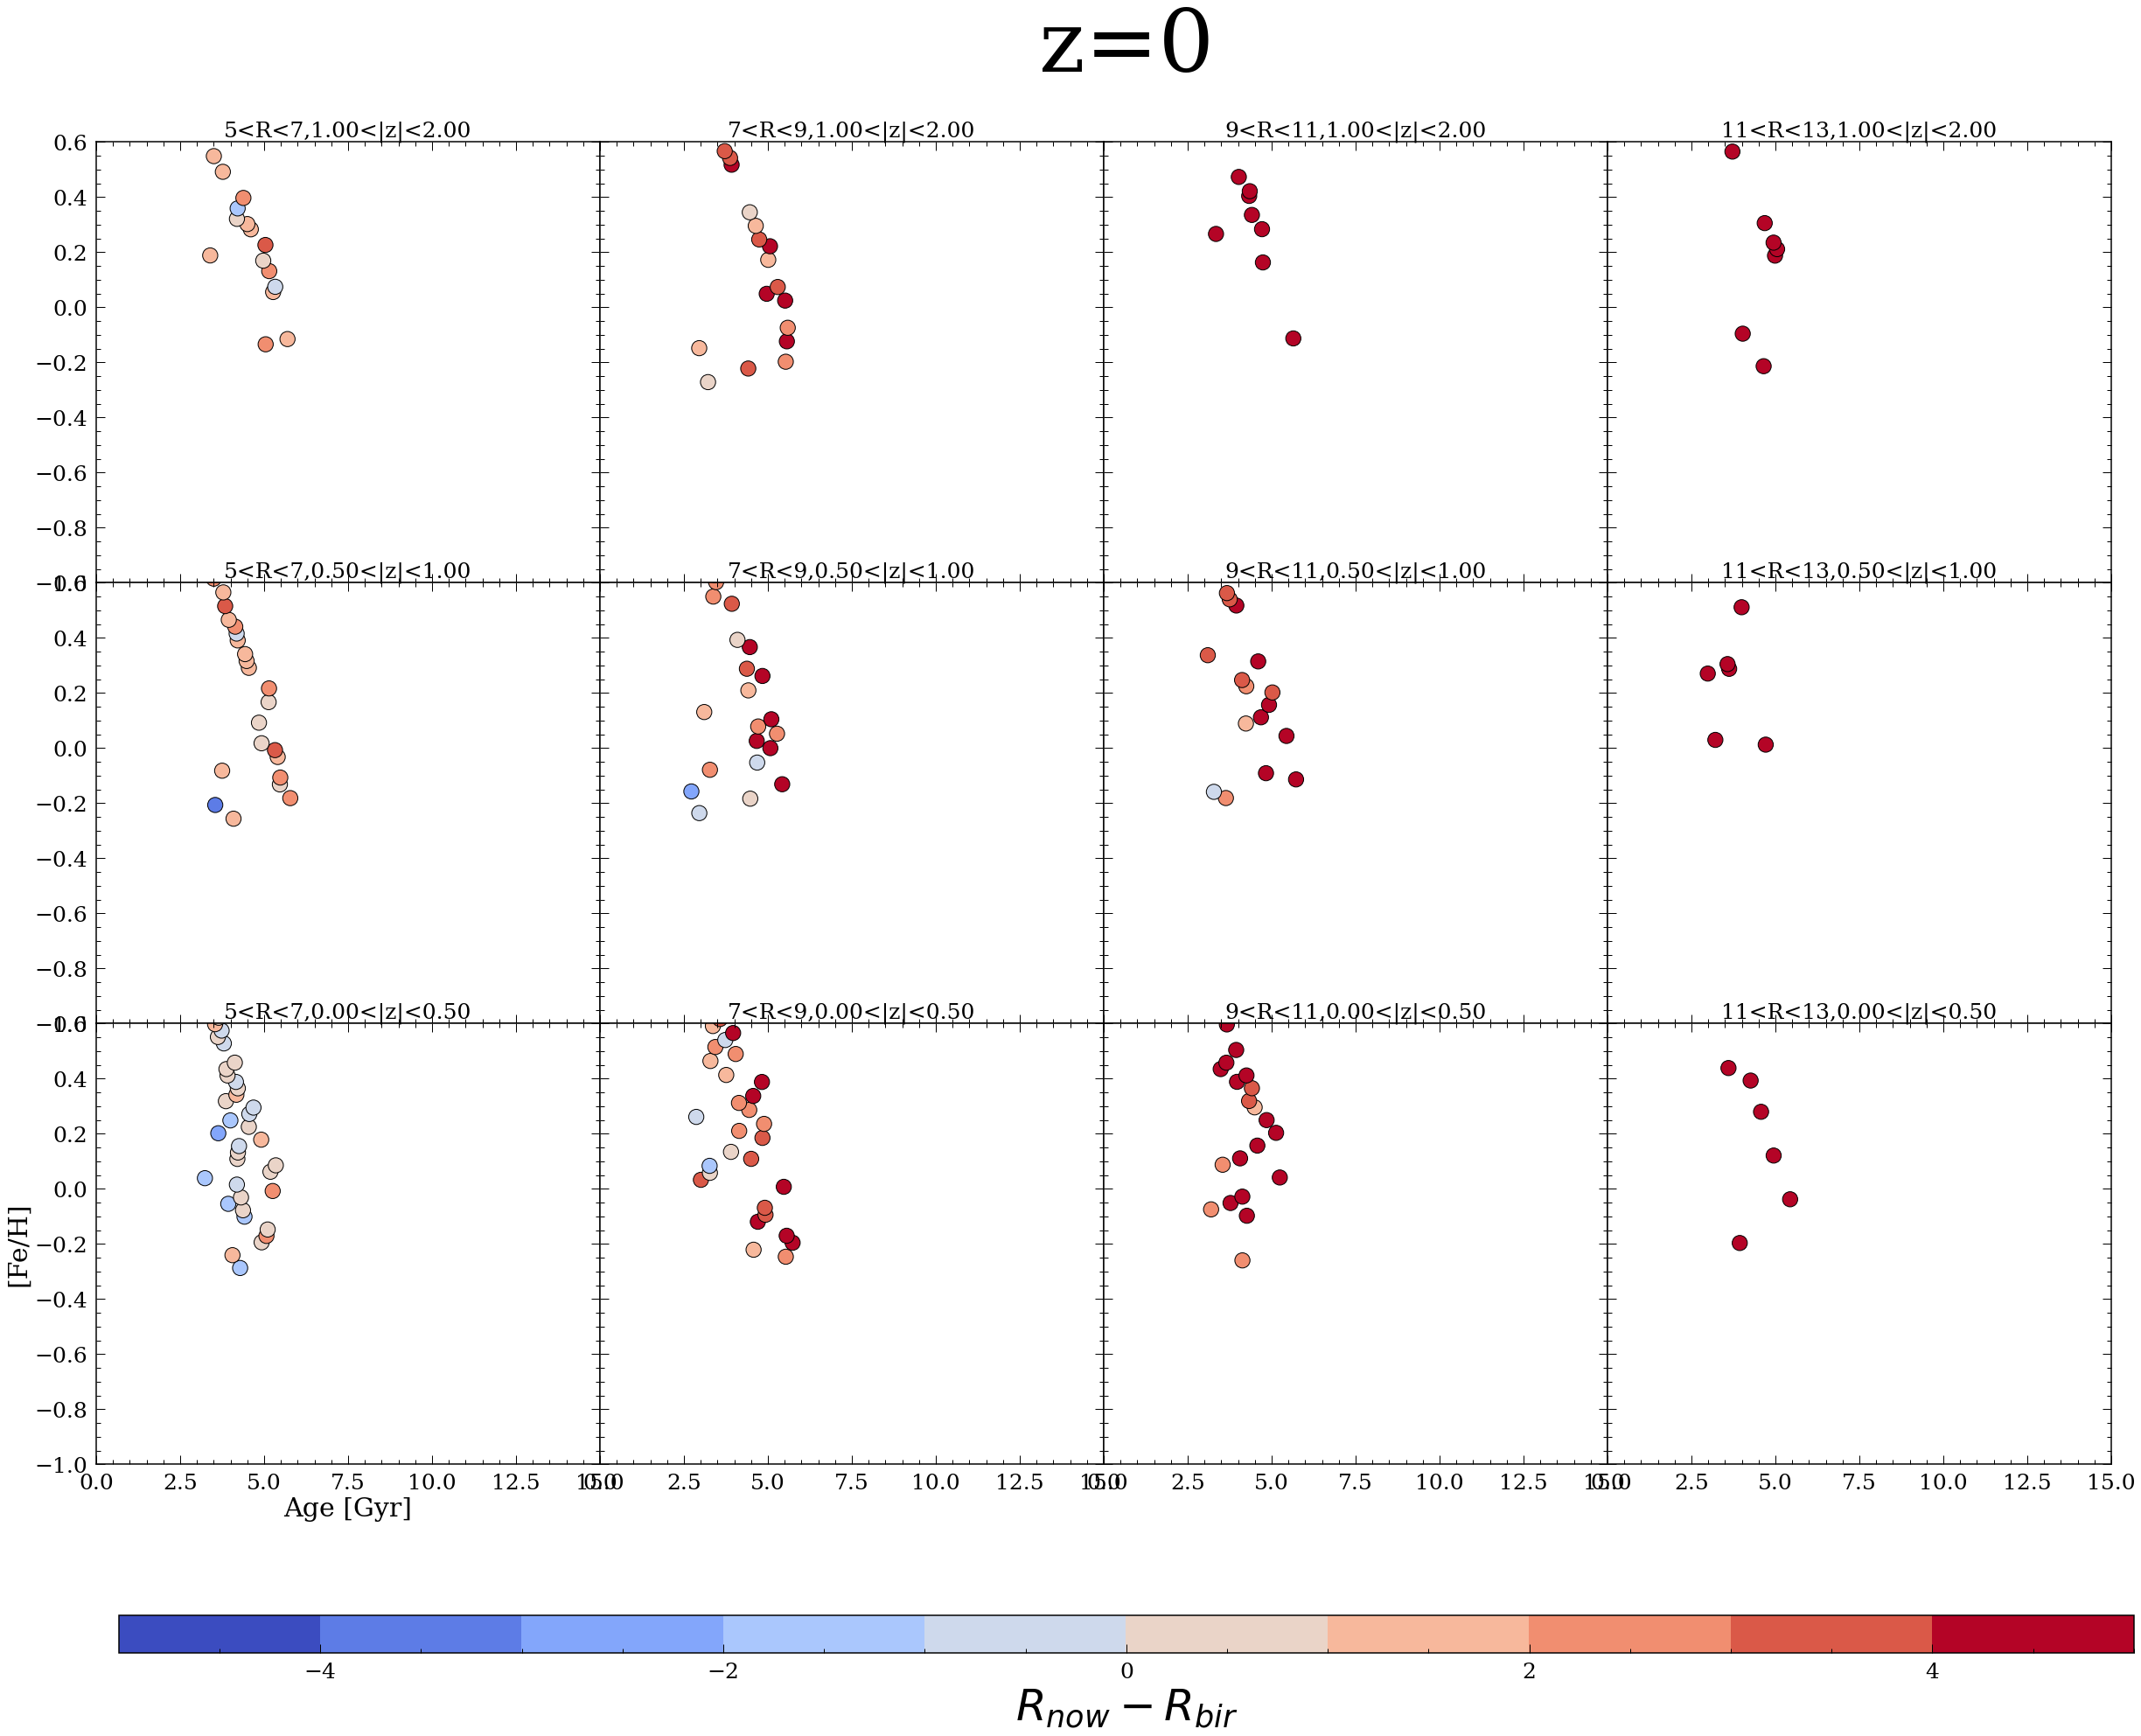

In [42]:
#data=data.loc[data['hi_low']==0]
# plotting as similar to paper
cmap = plt.cm.get_cmap('coolwarm',10)
Rbin=[2,1,0.5,0]
zbin=[5,7,9,11,13]

lims=[-5,5]

fig, axarr = plt.subplots(len(Rbin)-1,len(zbin)-1,gridspec_kw={'hspace': 0, 'wspace': 0},
                          figsize=(40,30))

bottom, top = 0.2, 0.9
left, right = 0.1, 0.9

fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.15, wspace=0.25)


for i in range(len(Rbin)-1):
    df_all=datafiles.loc[datafiles['z']>Rbin[i+1]]
    df_all=df_all.loc[df_all['z']<Rbin[i]]
        
    for j in range(len(zbin)-1):
        df_all_z=df_all.loc[abs(df_all['R'])>zbin[j]]
        df_all_z=df_all_z.loc[abs(df_all_z['R'])<zbin[j+1]]
        
        df_all_z=df_all_z.dropna(subset=['feh_scale','age'])
        
   
        meanfeh,meanage,meanage_err,meanjz,starnumb=getave_age(df_all_z['age'],df_all_z['feh_scale'],
                                                    jz=True,jzs=(df_all_z['dR']),fuc=np.median,Nbin=100)
        
        
        
        clear_output(wait = True)
        
        m=(meanfeh!=0)
        meanfeh,meanage,meanage_err,starnumb,meanjz=meanfeh[m],meanage[m],meanage_err[m],starnumb[m],meanjz[m]
        
        m2=starnumb>10
        filterage=gaussian_filter(meanage[m2], sigma=3)
        axarr[i,j].plot(filterage,meanfeh[m2],'k--',linewidth=5)
        
        #im=axarr[i,j].errorbar(meanage,meanfeh,xerr=meanage_err,fmt='k.')
        im=axarr[i,j].scatter(meanage,meanfeh,c=meanjz,s=300,vmin=lims[0],vmax=lims[1],edgecolor='k',cmap=cmap)
        
        
        axarr[i,j].set_xlim([0,15])
        if Rcut:
            axarr[i,j].set_ylim([-1,0.6])
        else:
            axarr[i,j].set_ylim([-1.5,0.6])

        axarr[i,j].set_title('%d<R<%d,%.2f<|z|<%.2f'%(zbin[j],zbin[j+1],Rbin[i+1],Rbin[i]),fontsize=25)
 
        if i!=len(Rbin)-2:
            axarr[i,j].set_xticklabels([])
        if j!=0:
            axarr[i,j].set_yticklabels([])
        
axarr[len(Rbin)-2,0].set_xlabel('Age [Gyr]')
axarr[len(Rbin)-2,0].set_ylabel('[Fe/H]')

cb_ax = fig.add_axes([0.109, 0.1, 0.8, 0.02])
cbar = fig.colorbar(im, cax=cb_ax,orientation = 'horizontal')
car = cbar.set_label('$R_{now}-R_{bir}$',fontsize = 50,labelpad = 5)

plt.text(0, 420, 'z=0',ha='center', va='center', rotation='horizontal',fontsize=100)

#plt.savefig('feage_2_79e12_0.png')



In [18]:
%matplotlib agg
count=0
cm = plt.cm.get_cmap('coolwarm',14)
for i in dirFiles:
    datafiles=pd.DataFrame(pd.read_pickle('./Data/trace_stars/'+i))
    datafiles['R']=np.sqrt(datafiles['x']**2+datafiles['y']**2)
    datafiles=pd.merge(datafiles,bgdata[['R_bir','iords']],left_on='iords',
                      right_on='iords',how='inner')
    
    plt.figure(figsize=(20,16))
    plt.subplot(2,2,1)
    plt.scatter(bgdata['x_today'],bgdata['y_today'],s=0.01,c='r',alpha=0.1)
    plt.scatter(datafiles['x'],datafiles['y'],s=0.01,c='k',alpha=0.1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.title('t='+i.split('.')[-2].split('_')[0],fontsize=25)
    
    plt.subplot(2,2,2)
    plt.scatter(bgdata['R'],bgdata['z_today'],s=0.01,c='r',alpha=0.1)
    plt.scatter(datafiles['R'],datafiles['z'],s=0.01,c='k',alpha=0.1)
    plt.xlabel('R')
    plt.ylabel('z')
    plt.ylim([-5,5])
    plt.xlim([0,20])
    
    plt.subplot(2,2,3)
    plt.scatter(bgdata['feh'],bgdata['ofe'],s=0.01,c='r',alpha=0.1)
    plt.scatter(datafiles['feh'],datafiles['ofe'],s=0.01,c='k',alpha=0.1)
    plt.xlabel('[Fe/H]')
    plt.ylabel('[O/Fe]')
    plt.xlim([-1.5,0.7])
    plt.ylim([-0.25,0.5])
    
    
    plt.subplot(2,2,4)
    plt.hexbin(bgdata['R_bir'].values, bgdata['R'].values,
                    C=bgdata['feh'].values, cmap=cm,vmin=-1.5,vmax=0.6, 
                    gridsize=300,extent=(0,30,0,30),
                    reduce_C_function = np.mean, mincnt=1,alpha=0.1)
    plt.hexbin(datafiles['R_bir'].values, datafiles['R'].values,
                    C=datafiles['feh'].values, cmap=cm,vmin=-1.5,vmax=0.6, 
                    gridsize=300,extent=(0,30,0,30),
                    reduce_C_function = np.mean, mincnt=1)
    plt.plot([0,30],[0,30])
    #plt.scatter(bgdata['R_bir'],bgdata['R'],s=0.01,c='r',alpha=0.5)
    #plt.scatter(datafiles['R_bir'],datafiles['R'],s=0.01,c='k',alpha=0.5)
    plt.xlabel('R_bir')
    plt.ylabel('R_now')
    plt.xlim([0,30])
    plt.ylim([0,30])
    cbar = plt.colorbar()
    car = cbar.set_label('[Fe/H]',fontsize = 25,labelpad = 5)
    
    
    plt.tight_layout()
    plt.savefig('bardata/'+str(count)+'.png')
    count=count+1
    plt.close()